In [2]:
### Cleaning up data ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/AirQualityUCI.csv', sep=';')

# Create timestamps
df.insert(0, 'Timestamp', pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S'))

# Drop useless columns
df = df.drop(['Unnamed: 15', 'Unnamed: 16', 'Date', 'Time'], axis=1)

# Columns to floats
for col in df.columns.drop('Timestamp'):
    df[col] = df[col].map(lambda x: float(str(x).replace(',', '.')))
    
# Add NaNs instead of 200
df = df.replace(-200, np.nan)

# Remove useless columns at end
df = df.loc[~pd.isnull(df['Timestamp']), :]

# Nice alternative dataframe with timestamps as index
df_ts = df.set_index('Timestamp', drop=True)

df.to_excel('output_data/cleaned.xlsx')

In [ ]:
import itertools

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler 
from collections import deque
from sklearn.metrics import root_mean_squared_error

# Impute missing ground truth data. This is purely an evaluation tool.

def get_train_test_validation(df_ts, *, target=None, validation=True):
    output_cols = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
    df_ts_input = df_ts.drop(output_cols, axis=1)
    df_ts_output = df_ts[output_cols]
    if target != None:
        df_ts_output = df_ts_output[[target]] 

    if not validation:
        df_train_X = df_ts_input[df_ts.index < '2005-01-01']
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2005-01-01']
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y 
    else:
        df_train_X = df_ts_input[df_ts.index < '2004-11-01']
        df_val_X = df_ts_input[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2004-11-01']
        df_val_y = df_ts_output[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y 
        

target = 'CO(GT)'
#df_train_X, df_train_y, df_test_X, df_test_y = get_train_test_validation(df_ts, target=target, validation=False)
df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y = get_train_test_validation(df_ts, target=target, validation=True)


class OnlineLinearModel:
    def __init__(self, hours_ahead_prediction, hyperparams, model_hyperparams):
        self.model = None
        self.shift = hours_ahead_prediction
        self.win_size = 50 
        self.scaler = None
        self.hyperparams = hyperparams
        self.model_hyperparams = model_hyperparams
        
    def feature_transform(self, train_X : pd.DataFrame, is_live):
        train_X = train_X.copy()

        # interpolation
        if is_live:
            train_X.ffill(inplace=True) 
        else:
            train_X.interpolate(method='time', inplace=True) # plot this
        train_X.dropna(inplace=True) # drop any columns which were NaN right at the start and could not be ffilled

        # normalisation
        train_X = pd.DataFrame(self.scaler.transform(train_X), columns=train_X.columns, index=train_X.index)

        # if is_live:
        #     window = train_X.head(self.win_size)
        #     max_seen = window.max(axis=0)
        #     min_seen = window.min(axis=0)
        #     for i in range(len(train_X)):
        #         max_seen = max_seen.combine(train_X.iloc[i], np.maximum)
        #         min_seen = min_seen.combine(train_X.iloc[i], np.minimum)
        #         train_X.iloc[i] = (train_X.iloc[i] - min_seen) / (max_seen - min_seen)
        # else:
        #     scaler = MinMaxScaler(copy=True)
        #     train_X = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns, index=train_X.index)
        

        # derived weekday, hour features
        # train_X['hour'] = train_X.index.hour
        # train_X['weekday'] = train_X.index.weekday
        # train_X['month'] = train_X.index.month
        
        # cyclic encoding
        def cycle_encode(series, max):
            angles = series * (2*np.pi/max)
            return np.sin(angles), np.cos(angles)
        train_X['hour_sin'], train_X['hour_cos'] = cycle_encode(train_X.index.hour, 24)
        train_X['weekday_sin'], train_X['weekday_cos'] = cycle_encode(train_X.index.weekday, 7)
        train_X['month_sin'], train_X['month_cos'] = cycle_encode(train_X.index.month, 12)
        train_X['is_weekend'] = train_X.index.weekday >= 5
        train_X['is_rush_hour'] = ((train_X.index.hour >= 6) & (train_X.index.hour <= 10)) | ((train_X.index.hour >= 18) & (train_X.index.hour <= 22)) 
        
        

        # collapse to window. Keep timestamp of the latest item in the window
        final_X = self._window_to_row(train_X.head(self.win_size))
        for i in range(self.win_size + 1, len(train_X)-1):
            final_X = pd.concat([final_X, self._window_to_row(train_X.iloc[i-self.win_size+1:i])])
        train_X = final_X
        
        return train_X
    
    def _window_to_row(self, window : pd.DataFrame):
        """
        Takes a window and outputs a row of data for prediction of shift
        Assumes window is normalised
        """ 
        
        lags = self.hyperparams['direct_lag_window']
        new_cols = [f'{col} lag_{i}'for i in range(lags) for col in window.columns ]
        df = pd.DataFrame([window.tail(lags).to_numpy().flat], columns=new_cols, index=window.tail(1).index)
        
        def lagged_sample(hours_back, nsamples):
            return window.tail(hours_back + (nsamples//2)).head(nsamples).mean()

        lagged_12h = lagged_sample(12, 4) 
        lagged_24h = lagged_sample(24, 6) 

        df['temp_avg_12h'] = lagged_12h['T']
        df['ah_avg_12h'] = lagged_12h['AH']
        df['rh_avg_12h'] = lagged_12h['RH']
        
        df['co_24h'] = lagged_24h['PT08.S1(CO)']
        df['co_12h'] = lagged_12h['PT08.S1(CO)']
        df['nox_12h'] = lagged_12h['PT08.S3(NOx)']
        df['no2_12h'] = lagged_12h['PT08.S4(NO2)']

        
        return df
    
    def train(self, train_X, train_y):
        self.scaler = MinMaxScaler().fit(train_X)
        train_X = self.feature_transform(train_X, False)
        
        train_y = train_y.interpolate(method='time')
        
        prediction_idx = train_X.index + pd.Timedelta(hours=self.shift)
        train_X = train_X[prediction_idx.isin(train_y.index)]
        train_y = train_y[train_y.index.isin(prediction_idx)]
        

        self.model = Ridge(**self.model_hyperparams).fit(train_X.to_numpy(), train_y.to_numpy()) 
        return self
    
    def predict(self, test_X):
        test_X = self.feature_transform(test_X, True)
        prediction_idx = test_X.index + pd.Timedelta(hours=self.shift)
        return pd.Series(self.model.predict(test_X.to_numpy()).flat, index=prediction_idx)


def equivalise(raw_true, raw_predictions):
    predictions = raw_predictions[raw_predictions.index.isin(raw_true.index)]
    true = raw_true[raw_true.index.isin(predictions.index)]
    return true, predictions
    
def grid_search(lag, train_X, train_y, val_X, val_y, hyperparams : dict, model_hyperparams : dict):
    """
    Runs a grid search. The train_y and val_y should NOT be shifted by the desired hours ahead to predict - the model does
    this automatically
    """
    hkeys, hvals = zip(*hyperparams.items())
    mhkeys, mhvals = zip(*model_hyperparams.items())
    hcombos = [x for x in itertools.product(*hvals)]
    mhcombos = [x for x in itertools.product(*mhvals)]

    best_rmse = float('inf')
    best_vals = None
    best_model = None
    
    for i, hcombo in enumerate(hcombos):
        for j, mhcombo in enumerate(mhcombos):
            hyperparams = {key: val for key, val in zip(hkeys, hcombo)}
            model_hyperparams = {key: val for key, val in zip(mhkeys, mhcombo)}
            model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(df_train_X, df_train_y)
            
            # evaluate
            true, predicted = equivalise(val_y, model.predict(val_X))
            rmse = root_mean_squared_error(true.to_numpy(), predicted.to_numpy()) 
            print(f'Evaluated hyperparameters {hyperparams} and model hyperparameters {model_hyperparams}. RMSE: {rmse}')
            if rmse < best_rmse:
                best_rmse = rmse 
                best_vals = (hyperparams, model_hyperparams)
                best_model = model
    
    return best_model, best_vals
    
    
lag = 1 
df_test_y_nona = df_test_y.dropna()[target]
df_val_y_nona = df_val_y.dropna()[target]

#model = OnlineLinearModel(lag).train(df_train_X, df_train_y)


# perhaps sensors lag true values in some way?
hyperparams = {
    'direct_lag_window': [3, 5, 8, 10, 15, 24, 48],
}
model_hyperparams = {
    'alpha': [0.3, 0.5, 1, 2, 5, 8]
}
model, vals = grid_search(lag, df_train_X, df_train_y, df_val_X, df_val_y_nona, hyperparams, model_hyperparams)

df_predict_y = model.predict(df_test_X)
naive_predictions = df_test_y.shift(lag).dropna()[target]

Evaluated hyperparameters {'direct_lag_window': 5} and model hyperparameters {'alpha': 0.5}. RMSE: 1.144310505100959
Evaluated hyperparameters {'direct_lag_window': 5} and model hyperparameters {'alpha': 1}. RMSE: 1.146741511748635
Evaluated hyperparameters {'direct_lag_window': 5} and model hyperparameters {'alpha': 2}. RMSE: 1.14978107807686
Evaluated hyperparameters {'direct_lag_window': 5} and model hyperparameters {'alpha': 5}. RMSE: 1.154653973736367
Evaluated hyperparameters {'direct_lag_window': 5} and model hyperparameters {'alpha': 8}. RMSE: 1.1579398018532145
Evaluated hyperparameters {'direct_lag_window': 8} and model hyperparameters {'alpha': 0.5}. RMSE: 1.1518452174695992
Evaluated hyperparameters {'direct_lag_window': 8} and model hyperparameters {'alpha': 1}. RMSE: 1.1550650214476343
Evaluated hyperparameters {'direct_lag_window': 8} and model hyperparameters {'alpha': 2}. RMSE: 1.1587294127203311
Evaluated hyperparameters {'direct_lag_window': 8} and model hyperparamet

#### Progress

- Model refuses to go below 0.97 RMSE even with grid search
- From residuals seems that it responds to spikes with too great a delay. Somehow incorporate momentum
- Willtry more features

In [143]:
### Ridge Version 2 ##


import itertools
import holidays
import multiprocessing
from scipy.stats import norm, linregress
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler 
from collections import deque
from sklearn.metrics import root_mean_squared_error

# Impute missing ground truth data. This is purely an evaluation tool.

def get_train_test_validation(df_ts, *, target=None, validation=True):
    output_cols = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
    df_ts_input = df_ts.drop(output_cols, axis=1)
    df_ts_output = df_ts[output_cols]
    if target != None:
        df_ts_output = df_ts_output[[target]] 

    if not validation:
        df_train_X = df_ts_input[df_ts.index < '2005-01-01']
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2005-01-01']
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y 
    else:
        df_train_X = df_ts_input[df_ts.index < '2004-11-01']
        df_val_X = df_ts_input[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2004-11-01']
        df_val_y = df_ts_output[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y 
        

target = 'CO(GT)'
#df_train_X, df_train_y, df_test_X, df_test_y = get_train_test_validation(df_ts, target=target, validation=False)
df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y = get_train_test_validation(df_ts, target=target, validation=True)


class OnlineLinearModel:
    def __init__(self, hours_ahead_prediction, hyperparams, model_hyperparams):
        self.model = None
        self.shift = hours_ahead_prediction
        self.win_size = 50 
        self.scaler = None
        self.hyperparams = hyperparams
        self.model_hyperparams = model_hyperparams
        
    def feature_transform(self, train_X : pd.DataFrame, is_live):
        train_X = train_X.copy()

        # interpolation
        if is_live:
            train_X.ffill(inplace=True) 
        else:
            train_X.interpolate(method='time', inplace=True) 
        train_X.dropna(inplace=True) # drop any columns which were NaN right at the start and could not be ffilled

        # initial normalisation
        train_X = pd.DataFrame(self.scaler.transform(train_X), columns=train_X.columns, index=train_X.index)
        
        # temporal feature encoding
        train_X = self._derive_temporal_features(train_X)

        # collapse to window. Keep timestamp of the latest item in the window
        final_X = self._window_to_row(train_X.head(self.win_size))
        for i in range(self.win_size + 1, len(train_X)-1):
            final_X = pd.concat([final_X, self._window_to_row(train_X.iloc[i-self.win_size+1:i])])
        train_X = final_X
        
        return train_X
    
    def _derive_temporal_features(self, train_X):
        # be careful to ensure that these are manually made normalised

        train_X = train_X.copy()

        # cyclic encoding
        def cycle_encode(series, max):
            angles = series * (2*np.pi/max)
            return np.sin(angles), np.cos(angles)

        train_X['hour_sin_24h'], train_X['hour_cos_24h'] = cycle_encode(train_X.index.hour, 24)
        train_X['hour_sin_12h'], train_X['hour_cos_12h'] = cycle_encode(train_X.index.hour % 12, 12) # 12h enhances separability for half-day cycle patterns
        train_X['weekday_sin'], train_X['weekday_cos'] = cycle_encode(train_X.index.weekday, 7)
        train_X['month_sin'], train_X['month_cos'] = cycle_encode(train_X.index.month, 12)
        
        # special markers
        train_X['is_weekend'] = train_X.index.weekday >= 5
        train_X['is_rush_hour'] = ((train_X.index.hour >= 6) & (train_X.index.hour <= 10)) | ((train_X.index.hour >= 18) & (train_X.index.hour <= 22)) 

        def days_from_public_hol(date):
            public_holidays = pd.Series(pd.Timestamp(x) for x in holidays.country_holidays('IT', years=[2004, 2005]).keys())
            x = public_holidays - pd.Series([date] * len(public_holidays))
            return x.abs().min().days
        def effect_of_public_hol(date, effect_scale=5):
            # use norm to get a bell shape, normalise it to 1
            return norm.pdf(days_from_public_hol(date), loc=0, scale=effect_scale) / norm.pdf(0, loc=0, scale=effect_scale)

        #days_from_hol = train_X.index.map(lambda x : days_from_public_hol(x))
        #train_X['days_from_public_hol'] = days_from_hol / days_from_hol.max()
        train_X['effect_of_public_hol'] = train_X.index.map(lambda x : effect_of_public_hol(x))

        return train_X
    
    def _window_to_row(self, window : pd.DataFrame):
        """
        Takes a window and outputs a row of data for prediction of shift
        Assumes window is normalised
        """ 
        
        # raw lags of most recent features
        lags = self.hyperparams['direct_lag_window']
        new_cols = [f'{col} lag_{i}'for i in range(lags) for col in window.columns ]
        df = pd.DataFrame([window.tail(lags).to_numpy().flat], columns=new_cols, index=window.tail(1).index)

        # lagged averages        
        def lagged_sample(hours_back, nsamples):
            return window.tail(hours_back + (nsamples//2)).head(nsamples).mean()            
        lagged_12h = lagged_sample(12, 4) 
        lagged_24h = lagged_sample(24, 6) 

        df['temp_avg_12h'] = lagged_12h['T']
        df['ah_avg_12h'] = lagged_12h['AH']
        df['rh_avg_12h'] = lagged_12h['RH']
        
        df['co_24h'] = lagged_24h['PT08.S1(CO)']
        df['co_12h'] = lagged_12h['PT08.S1(CO)']
        df['nox_12h'] = lagged_12h['PT08.S3(NOx)']
        df['no2_12h'] = lagged_12h['PT08.S4(NO2)']
        

        # ratios: ratio between NOx and NO2 reveals
        # freshness of traffic emissions.
        # def compress_01(x):
        #     # compresses a positive value into the 0-1 range with a long tail
        #     return 1. - np.exp(-np.max([0., x]))
        # nox_no2_ratio =  window['PT08.S3(NOx)'].iloc[-1] / (window['PT08.S4(NO2)'].iloc[-1] + 1e-6)
        # nox_no2_ratio_lag12 = lagged_12h['PT08.S3(NOx)'] / (lagged_12h['PT08.S4(NO2)'] + 1e-6)
        # df['nox_no2_ratio'] = compress_01(nox_no2_ratio)
        # df['nox_no2_ratio_lag12'] = compress_01(nox_no2_ratio_lag12)
        
        # # volatility of readings
        # df['co_volatility'] = window['PT08.S1(CO)'].tail(8).std()
        # df['nox_volatility'] = window['PT08.S3(NOx)'].tail(8).std()
        # df['no2_volatility'] = window['PT08.S4(NO2)'].tail(8).std()
        # df['temp_volatility'] = window['T'].tail(8).std()
        # df['rh_volatility'] = window['RH'].tail(8).std()
        
        # # # meteorogical interaction effects
        # df['t_rh_interaction'] = lagged_12h['T'] * lagged_12h['RH'] # humidity-temperature synergies

        # # # capturing momentum via trends
        def get_trend(series):
            vals = series.values
            regression = linregress(range(len(vals)), vals)
            slope = regression.slope
            return slope
        
        df['co_trend_6h'] = get_trend(window['PT08.S1(CO)'].tail(6))
        df['co_trend_24h'] = get_trend(window['PT08.S1(CO)'].tail(24))
        # df['nox_trend_6h'] = get_trend(window['PT08.S3(NOx)'].tail(6))
        # df['no2_trend_6h'] = get_trend(window['PT08.S4(NO2)'].tail(6))
        
        return df
    
    def _y_transform(self, train_y):
        train_y = train_y.interpolate(method='time')
        series = pd.Series(np.log1p(train_y.to_numpy()).flat, index=train_y.index)
        return series

    def _y_inverse_transform(self, pred_y):
        return pd.Series(np.expm1(pred_y.to_numpy()).flat, index=pred_y.index)
    
    def train(self, train_X, train_y):
        self.scaler = MinMaxScaler().fit(train_X)
        train_X = self.feature_transform(train_X, False)

        train_y = self._y_transform(train_y) 
        
        prediction_idx = train_X.index + pd.Timedelta(hours=self.shift)
        train_X = train_X[prediction_idx.isin(train_y.index)]
        train_y = train_y[train_y.index.isin(prediction_idx)]
        

        self.model = Ridge(**self.model_hyperparams).fit(train_X.to_numpy(), train_y.to_numpy()) 
        return self
    
    def predict(self, test_X):
        test_X = self.feature_transform(test_X, True)
        prediction_idx = test_X.index + pd.Timedelta(hours=self.shift)
        predictions = pd.Series(self.model.predict(test_X.to_numpy()).flat, index=prediction_idx)
        return self._y_inverse_transform(predictions)


def equivalise(raw_true, raw_predictions):
    predictions = raw_predictions[raw_predictions.index.isin(raw_true.index)]
    true = raw_true[raw_true.index.isin(predictions.index)]
    return true, predictions
    
def grid_search(lag, train_X, train_y, val_X, val_y, hyperparams : dict, model_hyperparams : dict):
    """
    Runs a grid search. The train_y and val_y should NOT be shifted by the desired hours ahead to predict - the model does
    this automatically
    """
    hkeys, hvals = zip(*hyperparams.items())
    mhkeys, mhvals = zip(*model_hyperparams.items())
    hcombos = [x for x in itertools.product(*hvals)]
    mhcombos = [x for x in itertools.product(*mhvals)]

    best_rmse = float('inf')
    best_vals = None
    best_model = None
    
    global test_model # function must be global to run in a pool
    def test_model(hyperparams, model_hyperparams):
        model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(df_train_X, df_train_y)
        true, predicted = equivalise(val_y, model.predict(val_X))
        rmse = root_mean_squared_error(true.to_numpy(), predicted.to_numpy()) 
        return ((hyperparams, model_hyperparams), rmse)
        
    results = []
    with multiprocessing.Pool() as pool:
        for i, hcombo in enumerate(hcombos):
            for j, mhcombo in enumerate(mhcombos):
                hyperparams = {key: val for key, val in zip(hkeys, hcombo)}
                model_hyperparams = {key: val for key, val in zip(mhkeys, mhcombo)}
                results.append(pool.apply_async(test_model, [hyperparams, model_hyperparams]) )
    
        for r in results:
            (hyperparams, model_hyperparams), rmse = r.get()
            print(f'Evaluated hyperparameters {hyperparams} and model hyperparameters {model_hyperparams}. RMSE: {rmse}')
            if rmse < best_rmse:
                best_rmse = rmse 
                best_vals = (hyperparams, model_hyperparams)
                best_model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(df_train_X, df_train_y)
        
        return best_model, best_vals
    
    
lag = 1 
df_test_y_nona = df_test_y.dropna()[target]
df_val_y_nona = df_val_y.dropna()[target]

#model = OnlineLinearModel(lag).train(df_train_X, df_train_y)


# hyperparams = {
#     'direct_lag_window': [3, 7, 14, 26, 49],
# }
# model_hyperparams = {
#     'alpha': [0.05, 0.1, 0.2, 0.5, 1, 2, 5],
#     'l1_ratio': [0.02, 0.05, 0.1, 0.3, 0.7]
# }
hyperparams = {
    'direct_lag_window': [12]#, 14],
}
model_hyperparams = {
    #'fit_intercept': [True]
    'alpha': [100, 200, 400],#, 0.1, 1],
    # 'l1_ratio': [0.001]#, 0.02, 0.1]
}
model, vals = grid_search(lag, df_train_X, df_train_y, df_val_X, df_val_y_nona, hyperparams, model_hyperparams)

df_predict_y = model.predict(df_test_X)
naive_predictions = df_test_y.shift(lag).dropna()[target]

Evaluated hyperparameters {'direct_lag_window': 12} and model hyperparameters {'alpha': 100}. RMSE: 1.0956334035858823
Evaluated hyperparameters {'direct_lag_window': 12} and model hyperparameters {'alpha': 200}. RMSE: 1.1058816749370477
Evaluated hyperparameters {'direct_lag_window': 12} and model hyperparameters {'alpha': 400}. RMSE: 1.1377744504407183


({'direct_lag_window': 1}, {'alpha': 10})


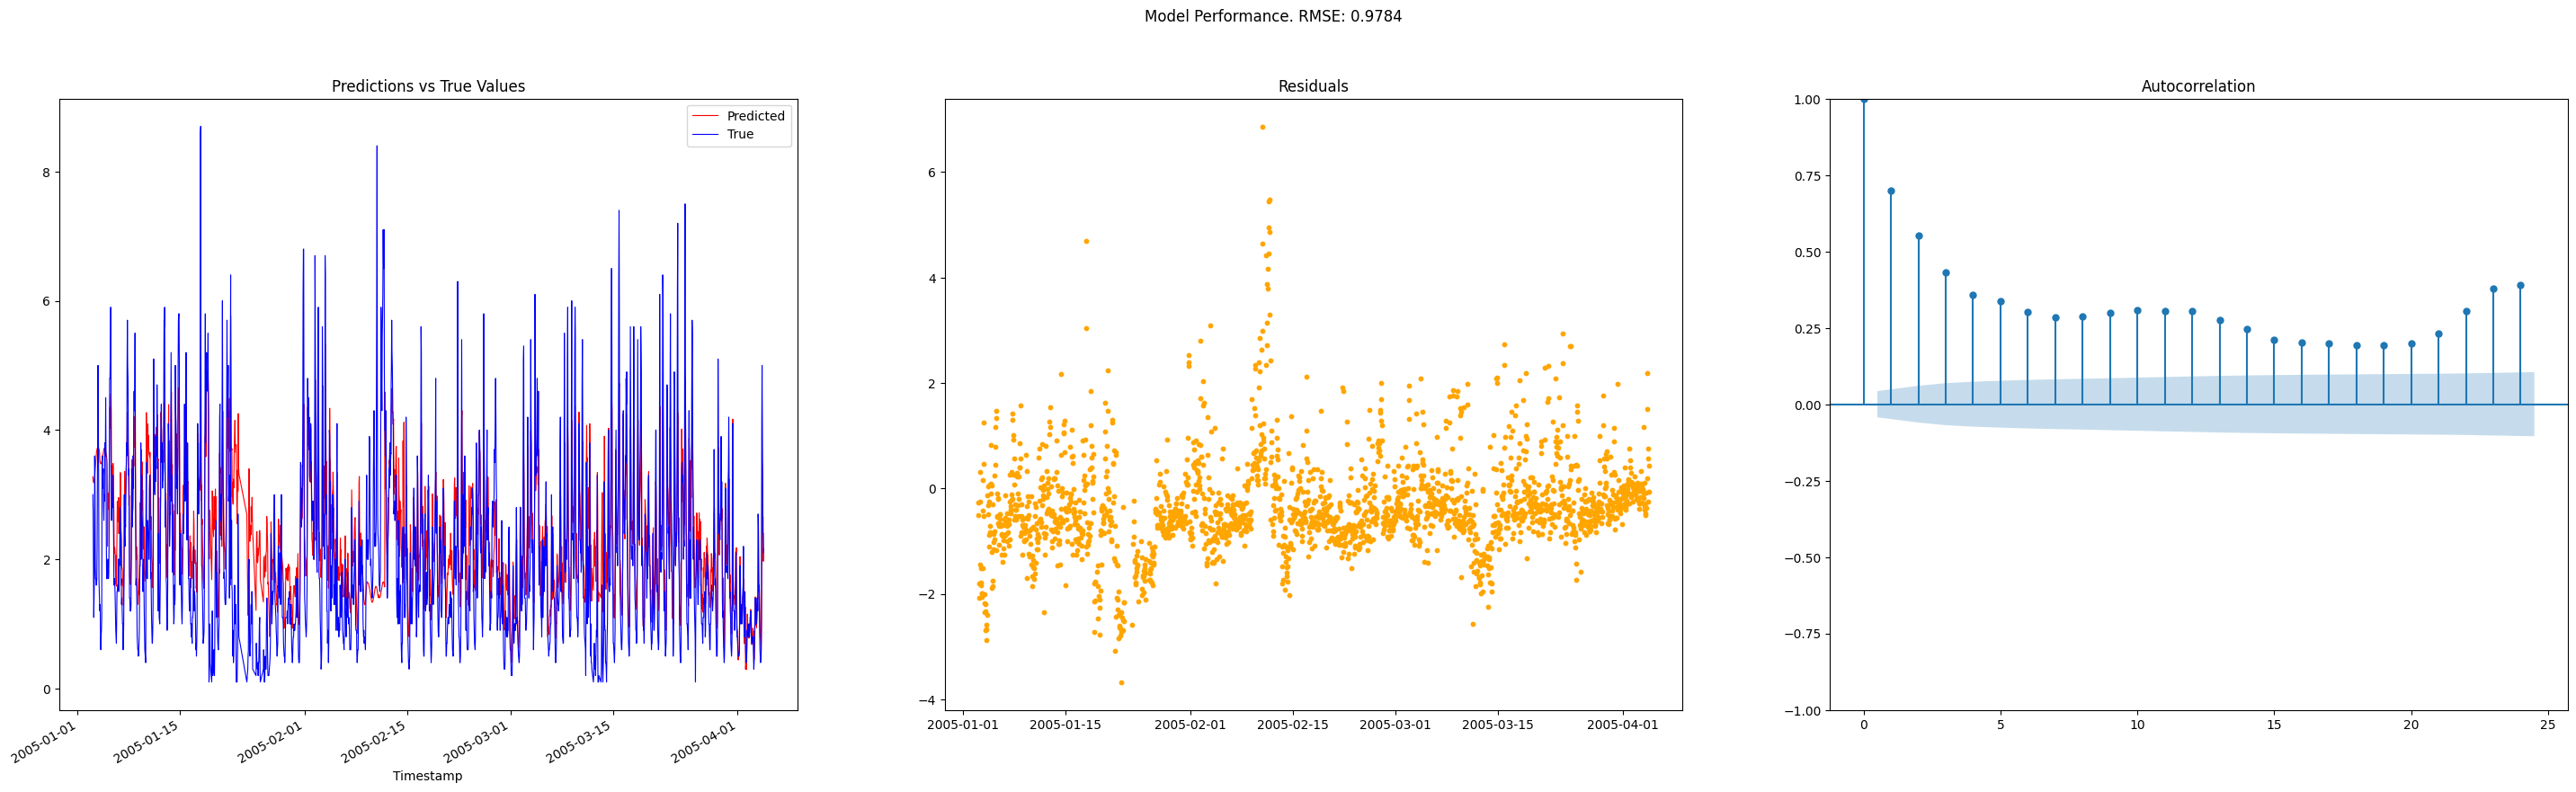

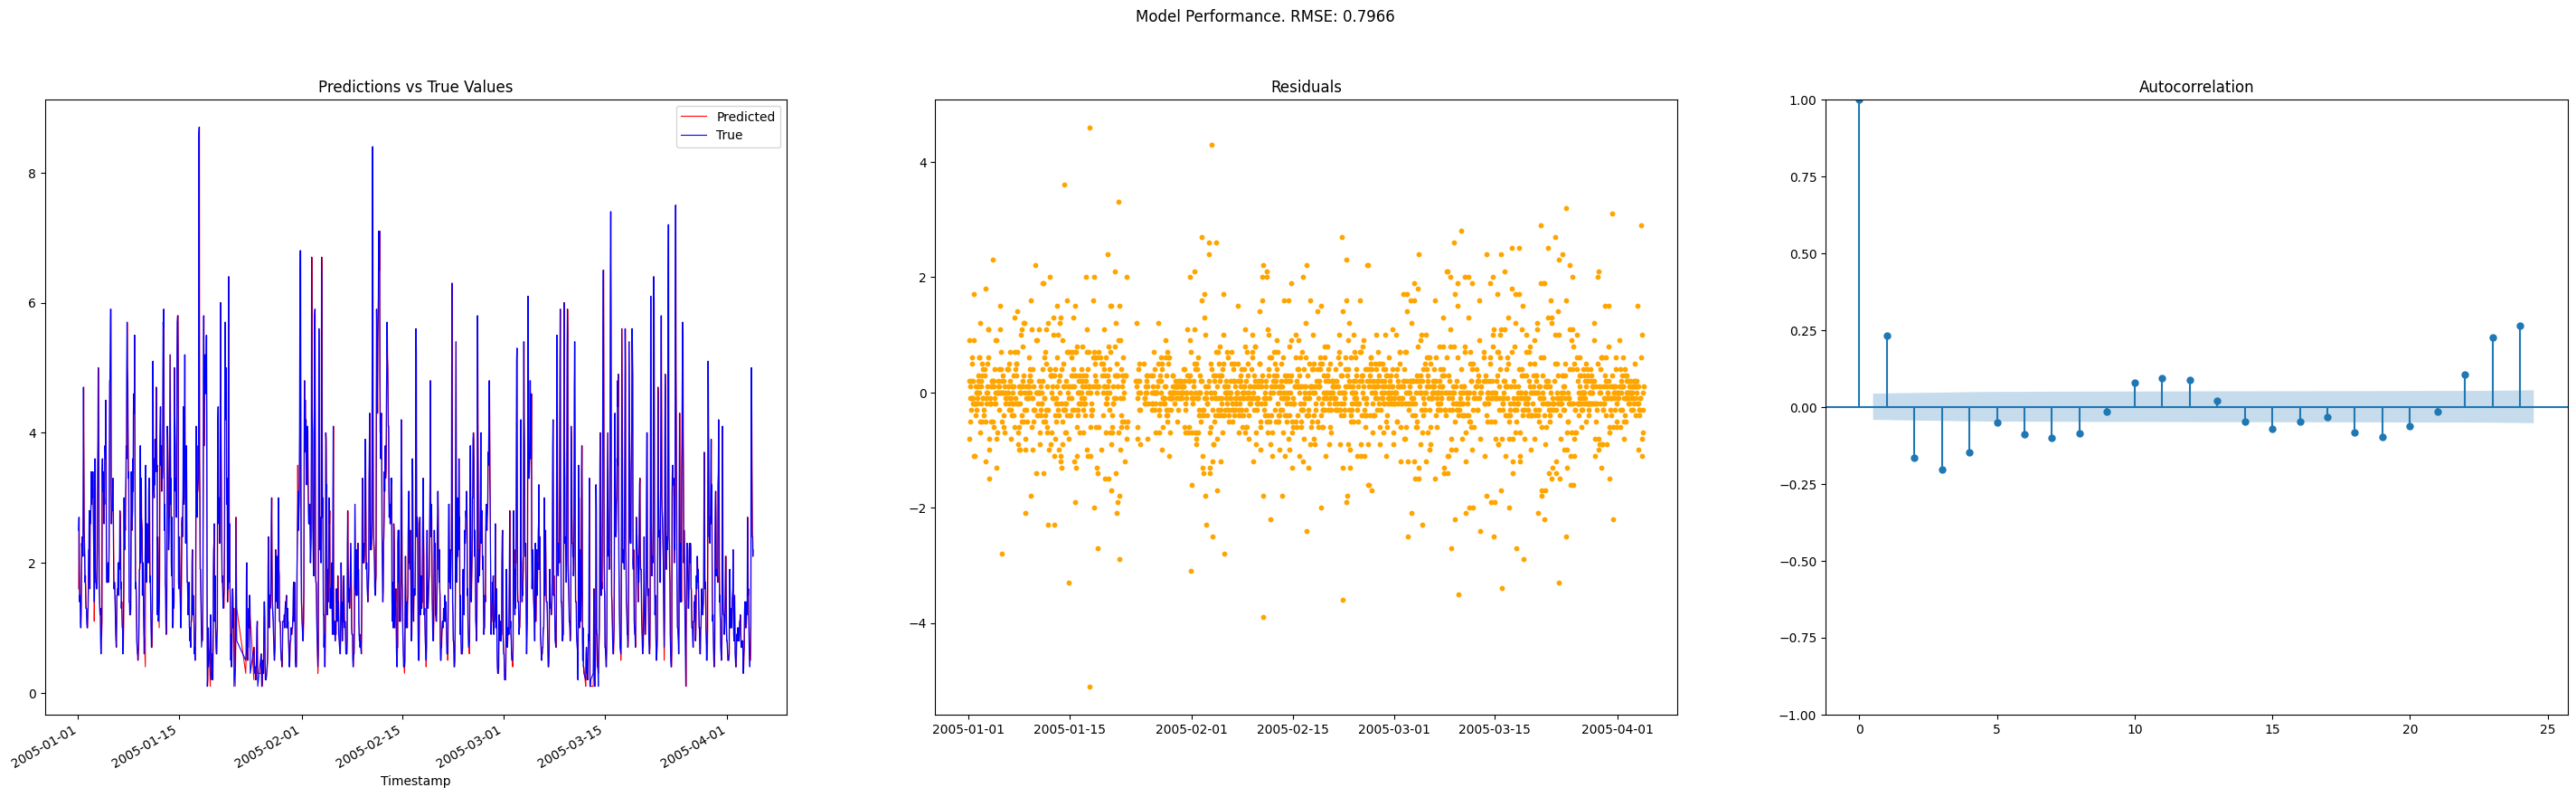

In [156]:
from statsmodels.graphics.tsaplots import plot_acf 

def evaluate(true, predictions):
    # normalise indices
    true, predictions = equivalise(true, predictions)
    
    # plot
    fig, ax = plt.subplots(1, 3, figsize=(36, 10))
    
    predictions.rename('Predicted')
    true.rename('True')

    line_pred = predictions.plot(linewidth=0.8, color='red', ax=ax[0], label='Predicted')
    line_true = true.plot(linewidth=0.8, color='blue', ax=ax[0], label='True')
    ax[0].set_title('Predictions vs True Values')
    ax[0].legend()
    
    residuals = true - predictions
    ax[1].scatter(residuals.index, residuals.values, s=10, color='orange')
    ax[1].set_title('Residuals')
    
    rmse = root_mean_squared_error(true.to_numpy(), predictions.to_numpy())
    
    # acf of residuals measures correlation between two residuals - spike at lag 1
    # means that model has undercaptured short term momentum.
    # ideally residuals should just be in the form of noise, so no autocorellation. Low ACF means model extracted all forecastable signal
    plot_acf(residuals, ax=ax[2], lags=24)
    
    fig.suptitle(f'Model Performance. RMSE: {rmse:.4f}')
    
print(vals)
evaluate(df_test_y_nona, df_predict_y)
evaluate(df_test_y_nona, naive_predictions)

#### Progress
- After adding log scaling it seems much more powerful regularisation is required since can overestimate significantly. However by looking at graph it looks like pattern of predictions matches better.

The ridge regression now has optimal hyperparameter alpha=100, suggesting that the exponential scaling of the output variable makes the model prone to large swings. The autocorrelation at lag 1 is high at around 0.7. It seems that the model does not respond quickly enough to changes in the data: if a spike occurs it predicts a spike shortly afterwards when it has already dropped back down.

In [ ]:
### Ridge Version 3: simpler and with less memory to allow spikes ###

import itertools
import holidays
import multiprocessing
from scipy.stats import norm, linregress
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler 
from collections import deque
from sklearn.metrics import root_mean_squared_error

# Impute missing ground truth data. This is purely an evaluation tool.

def get_train_test_validation(df_ts, *, target=None, validation=True):
    output_cols = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
    df_ts_input = df_ts.drop(output_cols, axis=1)
    df_ts_output = df_ts[output_cols]
    if target != None:
        df_ts_output = df_ts_output[[target]] 

    if not validation:
        df_train_X = df_ts_input[df_ts.index < '2005-01-01']
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2005-01-01']
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y 
    else:
        df_train_X = df_ts_input[df_ts.index < '2004-11-01']
        df_val_X = df_ts_input[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2004-11-01']
        df_val_y = df_ts_output[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y 
        

target = 'CO(GT)'
#df_train_X, df_train_y, df_test_X, df_test_y = get_train_test_validation(df_ts, target=target, validation=False)
df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y = get_train_test_validation(df_ts, target=target, validation=True)


class OnlineLinearModel:
    def __init__(self, hours_ahead_prediction, hyperparams, model_hyperparams):
        self.model = None
        self.shift = hours_ahead_prediction
        self.win_size = 50 
        self.scaler = None
        self.hyperparams = hyperparams
        self.model_hyperparams = model_hyperparams
        
    def feature_transform(self, train_X : pd.DataFrame, is_live):
        train_X = train_X.copy()

        # interpolation
        if is_live:
            train_X.ffill(inplace=True) 
        else:
            train_X.interpolate(method='time', inplace=True) 
        train_X.dropna(inplace=True) # drop any columns which were NaN right at the start and could not be ffilled

        # initial normalisation
        train_X = pd.DataFrame(self.scaler.transform(train_X), columns=train_X.columns, index=train_X.index)
        
        # temporal feature encoding
        train_X = self._derive_temporal_features(train_X)

        # collapse to window. Keep timestamp of the latest item in the window
        final_X = self._window_to_row(train_X.head(self.win_size))
        for i in range(self.win_size + 1, len(train_X)-1):
            final_X = pd.concat([final_X, self._window_to_row(train_X.iloc[i-self.win_size+1:i])])
        train_X = final_X
        
        return train_X
    
    def _derive_temporal_features(self, train_X):
        # be careful to ensure that these are manually made normalised

        train_X = train_X.copy()

        # cyclic encoding
        def cycle_encode(series, max):
            angles = series * (2*np.pi/max)
            return np.sin(angles), np.cos(angles)

        train_X['hour_sin_24h'], train_X['hour_cos_24h'] = cycle_encode(train_X.index.hour, 24)
        train_X['weekday_sin'], train_X['weekday_cos'] = cycle_encode(train_X.index.weekday, 7)
        train_X['month_sin'], train_X['month_cos'] = cycle_encode(train_X.index.month, 12)
        
        # special markers
        train_X['is_weekend'] = train_X.index.weekday >= 5
        train_X['is_rush_hour'] = ((train_X.index.hour >= 6) & (train_X.index.hour <= 10)) | ((train_X.index.hour >= 18) & (train_X.index.hour <= 22)) 

        def days_from_public_hol(date):
            public_holidays = pd.Series(pd.Timestamp(x) for x in holidays.country_holidays('IT', years=[2004, 2005]).keys())
            x = public_holidays - pd.Series([date] * len(public_holidays))
            return x.abs().min().days
        def effect_of_public_hol(date, effect_scale=5):
            # use norm to get a bell shape, normalise it to 1
            return norm.pdf(days_from_public_hol(date), loc=0, scale=effect_scale) / norm.pdf(0, loc=0, scale=effect_scale)

        #days_from_hol = train_X.index.map(lambda x : days_from_public_hol(x))
        #train_X['days_from_public_hol'] = days_from_hol / days_from_hol.max()
        train_X['effect_of_public_hol'] = train_X.index.map(lambda x : effect_of_public_hol(x))
         
        return train_X
    
    def _window_to_row(self, window : pd.DataFrame):
        """
        Takes a window and outputs a row of data for prediction of shift
        Assumes window is normalised
        """ 
        
        # raw lags of most recent features
        lags = self.hyperparams['direct_lag_window']
        new_cols = [f'{col} lag_{i}'for i in range(lags) for col in window.columns ]
        df = pd.DataFrame([window.tail(lags).to_numpy().flat], columns=new_cols, index=window.tail(1).index)

        # lagged averages        
        def lagged_sample(hours_back, nsamples):
            return window.tail(hours_back + (nsamples//2)).head(nsamples).mean()            
        lagged_12h = lagged_sample(12, 4) 
        lagged_24h = lagged_sample(24, 6) 

        df['temp_avg_12h'] = lagged_12h['T']
        # df['ah_avg_12h'] = lagged_12h['AH']
        # df['rh_avg_12h'] = lagged_12h['RH']
        
        df['co_24h'] = lagged_24h['PT08.S1(CO)']
        #df['co_12h'] = lagged_12h['PT08.S1(CO)']
        #df['nox_12h'] = lagged_12h['PT08.S3(NOx)']
        #df['no2_12h'] = lagged_12h['PT08.S4(NO2)']
        

        # ratios: ratio between NOx and NO2 reveals
        # freshness of traffic emissions.
        # def compress_01(x):
        #     # compresses a positive value into the 0-1 range with a long tail
        #     return 1. - np.exp(-np.max([0., x]))
        # nox_no2_ratio =  window['PT08.S3(NOx)'].iloc[-1] / (window['PT08.S4(NO2)'].iloc[-1] + 1e-6)
        # nox_no2_ratio_lag12 = lagged_12h['PT08.S3(NOx)'] / (lagged_12h['PT08.S4(NO2)'] + 1e-6)
        # df['nox_no2_ratio'] = compress_01(nox_no2_ratio)
        # df['nox_no2_ratio_lag12'] = compress_01(nox_no2_ratio_lag12)
        
        # # volatility of readings
        df['co_volatility'] = window['PT08.S1(CO)'].tail(8).std()
        # df['nox_volatility'] = window['PT08.S3(NOx)'].tail(8).std()
        # df['no2_volatility'] = window['PT08.S4(NO2)'].tail(8).std()
        df['temp_volatility'] = window['T'].tail(8).std()
        # df['rh_volatility'] = window['RH'].tail(8).std()
        
        # # # meteorogical interaction effects
        # df['t_rh_interaction'] = lagged_12h['T'] * lagged_12h['RH'] # humidity-temperature synergies
        df['co_delta_1h'] = window['PT08.S1(CO)'].tail(2).diff().iloc[-1]
        df['nox_delta_3h'] = window['PT08.S3(NOx)'].tail(4).diff(3).iloc[-1]
        df['temp_delta_1h'] = window['T'].tail(2).diff().iloc[-1]

        # # # capturing momentum via trends
        def get_trend(series):
            vals = series.values
            regression = linregress(range(len(vals)), vals)
            slope = regression.slope
            return slope
        
        df['co_trend_6h'] = get_trend(window['PT08.S1(CO)'].tail(6))
        #df['co_trend_24h'] = get_trend(window['PT08.S1(CO)'].tail(24))
        
        ar_weights = [0.7, 0.2, 0.1]
        df['co_proxy'] = sum(w * window['PT08.S1(CO)'].iloc[-(i+1)] for i, w in enumerate(ar_weights))
        # df['nox_trend_6h'] = get_trend(window['PT08.S3(NOx)'].tail(6))
        # df['no2_trend_6h'] = get_trend(window['PT08.S4(NO2)'].tail(6))
        
        return df
    
    def _y_transform(self, train_y):
        train_y = train_y.interpolate(method='time')
        return train_y
        series = pd.Series(np.log1p(train_y.to_numpy()).flat, index=train_y.index)
        return series

    def _y_inverse_transform(self, pred_y):
        return pred_y
        return pd.Series(np.expm1(pred_y.to_numpy()).flat, index=pred_y.index)
    
    def train(self, train_X, train_y):
        self.scaler = MinMaxScaler().fit(train_X)
        train_X = self.feature_transform(train_X, False)

        train_y = self._y_transform(train_y) 
        
        prediction_idx = train_X.index + pd.Timedelta(hours=self.shift)
        train_X = train_X[prediction_idx.isin(train_y.index)]
        train_y = train_y[train_y.index.isin(prediction_idx)]
        

        self.model = Ridge(**self.model_hyperparams).fit(train_X.to_numpy(), train_y.to_numpy()) 
        return self
    
    def predict(self, test_X):
        test_X = self.feature_transform(test_X, True)
        prediction_idx = test_X.index + pd.Timedelta(hours=self.shift)
        predictions = pd.Series(self.model.predict(test_X.to_numpy()).flat, index=prediction_idx)
        return self._y_inverse_transform(predictions)


def equivalise(raw_true, raw_predictions):
    predictions = raw_predictions[raw_predictions.index.isin(raw_true.index)]
    true = raw_true[raw_true.index.isin(predictions.index)]
    return true, predictions
    
def grid_search(lag, train_X, train_y, val_X, val_y, hyperparams : dict, model_hyperparams : dict):
    """
    Runs a grid search. The train_y and val_y should NOT be shifted by the desired hours ahead to predict - the model does
    this automatically
    """
    hkeys, hvals = zip(*hyperparams.items())
    mhkeys, mhvals = zip(*model_hyperparams.items())
    hcombos = [x for x in itertools.product(*hvals)]
    mhcombos = [x for x in itertools.product(*mhvals)]

    best_rmse = float('inf')
    best_vals = None
    best_model = None
    
    global test_model # function must be global to run in a pool
    def test_model(hyperparams, model_hyperparams):
        model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(df_train_X, df_train_y)
        true, predicted = equivalise(val_y, model.predict(val_X))
        rmse = root_mean_squared_error(true.to_numpy(), predicted.to_numpy()) 
        return ((hyperparams, model_hyperparams), rmse)
        
    results = []
    with multiprocessing.Pool() as pool:
        for i, hcombo in enumerate(hcombos):
            for j, mhcombo in enumerate(mhcombos):
                hyperparams = {key: val for key, val in zip(hkeys, hcombo)}
                model_hyperparams = {key: val for key, val in zip(mhkeys, mhcombo)}
                results.append(pool.apply_async(test_model, [hyperparams, model_hyperparams]) )
    
        for r in results:
            (hyperparams, model_hyperparams), rmse = r.get()
            print(f'Evaluated hyperparameters {hyperparams} and model hyperparameters {model_hyperparams}. RMSE: {rmse}')
            if rmse < best_rmse:
                best_rmse = rmse 
                best_vals = (hyperparams, model_hyperparams)
                best_model = OnlineLinearModel(lag, hyperparams=hyperparams, model_hyperparams=model_hyperparams).train(df_train_X, df_train_y)
        
        return best_model, best_vals
    
    
lag = 1 
df_test_y_nona = df_test_y.dropna()[target]
df_val_y_nona = df_val_y.dropna()[target]

#model = OnlineLinearModel(lag).train(df_train_X, df_train_y)


# hyperparams = {
#     'direct_lag_window': [3, 7, 14, 26, 49],
# }
# model_hyperparams = {
#     'alpha': [0.05, 0.1, 0.2, 0.5, 1, 2, 5],
#     'l1_ratio': [0.02, 0.05, 0.1, 0.3, 0.7]
# }
hyperparams = {
    'direct_lag_window': [1, 3, 6, 12],
}
model_hyperparams = {
    #'fit_intercept': [True]
    'alpha': [0.1, 1, 10, 15],#, 0.1, 1],
    # 'l1_ratio': [0.001]#, 0.02, 0.1]
}
model, vals = grid_search(lag, df_train_X, df_train_y, df_val_X, df_val_y_nona, hyperparams, model_hyperparams)

df_predict_y = model.predict(df_test_X)
naive_predictions = df_test_y.shift(lag).dropna()[target]

#### Hyperparameter search output

Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.02}. RMSE: 1.245197482550143
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.05}. RMSE: 1.2491404356662388
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.1}. RMSE: 1.2562419345493905
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.3}. RMSE: 1.279753362794299
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.7}. RMSE: 1.3143540459204062
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.02}. RMSE: 1.3059854737184597
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.05}. RMSE: 1.315862860897426
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.1}. RMSE: 1.3330390966922259
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.3}. RMSE: 1.393838587606323
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.7}. RMSE: 1.515258581880851
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.02}. RMSE: 1.3808816801344181
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.05}. RMSE: 1.4014201507904587
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.1}. RMSE: 1.4335346386962844
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.3}. RMSE: 1.566263489476867
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.7}. RMSE: 1.7769876079221298
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.02}. RMSE: 1.5028684679887363
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.05}. RMSE: 1.5458503841136952
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.1}. RMSE: 1.618201357333745
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.3}. RMSE: 1.8314710692301404
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.02}. RMSE: 1.617594713873774
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.05}. RMSE: 1.6870462414225633
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.1}. RMSE: 1.7873511380283524
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.02}. RMSE: 1.7438877321166049
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.05}. RMSE: 1.8353340453508589
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.1}. RMSE: 1.9228886218032233
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.02}. RMSE: 1.8868667817003328
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.05}. RMSE: 1.9410809296861393
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.1}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 3} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.02}. RMSE: 1.2415893573697754
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.05}. RMSE: 1.2454678850668492
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.1}. RMSE: 1.2543296891509006
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.3}. RMSE: 1.2809744914013326
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.7}. RMSE: 1.312888398684879
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.02}. RMSE: 1.2996329381013358
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.05}. RMSE: 1.3120492077920836
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.1}. RMSE: 1.3329229476056739
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.3}. RMSE: 1.3945919153901487
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.7}. RMSE: 1.510206114759491
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.02}. RMSE: 1.3693085171406152
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.05}. RMSE: 1.394598083631171
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.1}. RMSE: 1.431078606011857
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.3}. RMSE: 1.5583257201239042
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.7}. RMSE: 1.7617013354216646
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.02}. RMSE: 1.4720284358947753
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.05}. RMSE: 1.5221143320759274
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.1}. RMSE: 1.5921899515654794
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.3}. RMSE: 1.8020570848429553
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.02}. RMSE: 1.5630676186923607
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.05}. RMSE: 1.6383764645679948
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.1}. RMSE: 1.741927211009031
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.02}. RMSE: 1.674753570488043
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.05}. RMSE: 1.7821435852594285
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.1}. RMSE: 1.9085038065657212
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.02}. RMSE: 1.842146993521688
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.05}. RMSE: 1.937873193270609
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.1}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 7} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.02}. RMSE: 1.255109760423932
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.05}. RMSE: 1.2553423137480881
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.1}. RMSE: 1.2590317360655756
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.3}. RMSE: 1.282341520902617
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.7}. RMSE: 1.3135842599814131
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.02}. RMSE: 1.30806359531519
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.05}. RMSE: 1.316620355143351
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.1}. RMSE: 1.3348858312034577
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.3}. RMSE: 1.3978683658220152
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.7}. RMSE: 1.510584042762014
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.02}. RMSE: 1.37391846975696
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.05}. RMSE: 1.3985729982534063
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.1}. RMSE: 1.4350977072035462
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.3}. RMSE: 1.5577417859535354
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.7}. RMSE: 1.758501657912019
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.02}. RMSE: 1.4721502141206433
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.05}. RMSE: 1.5222180373047762
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.1}. RMSE: 1.5866072994870042
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.3}. RMSE: 1.7899959022365899
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.02}. RMSE: 1.5490929241858638
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.05}. RMSE: 1.6208066499606966
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.1}. RMSE: 1.717531739976175
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.02}. RMSE: 1.638823877308734
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.05}. RMSE: 1.747164130548361
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.1}. RMSE: 1.8968393991186414
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.02}. RMSE: 1.7996453725950081
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.05}. RMSE: 1.9340123806759077
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.1}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 14} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
/home/joel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.309e+00, tolerance: 9.431e-01
  model = cd_fast.enet_coordinate_descent(
/home/joel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.621e+00, tolerance: 9.431e-01
  model = cd_fast.enet_coordinate_descent(
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.02}. RMSE: 1.2565015949478688
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.05}. RMSE: 1.2531740041851789
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.1}. RMSE: 1.2509841324278566
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.3}. RMSE: 1.272944140592487
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.7}. RMSE: 1.3072564719720723
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.02}. RMSE: 1.299320637166562
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.05}. RMSE: 1.3034564079831812
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.1}. RMSE: 1.3210594433453757
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.3}. RMSE: 1.3819804165857594
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.7}. RMSE: 1.5070292571328703
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.02}. RMSE: 1.3566145310627522
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.05}. RMSE: 1.3818599847210948
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.1}. RMSE: 1.417238895791634
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.3}. RMSE: 1.5524868851458846
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.7}. RMSE: 1.7564166673185126
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.02}. RMSE: 1.4557473761993769
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.05}. RMSE: 1.5081897462346907
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.1}. RMSE: 1.5771097494741027
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.3}. RMSE: 1.7841561374329564
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.02}. RMSE: 1.534239201075872
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.05}. RMSE: 1.6076327159837305
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.1}. RMSE: 1.700992112625252
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.02}. RMSE: 1.6149883289780125
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.05}. RMSE: 1.721329611372831
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.1}. RMSE: 1.8886065198342201
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.02}. RMSE: 1.7628507248529561
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.05}. RMSE: 1.9298331847429386
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.1}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 26} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
/home/joel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.846e+01, tolerance: 9.431e-01
  model = cd_fast.enet_coordinate_descent(
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.02}. RMSE: 1.2728042521938416
/home/joel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e+00, tolerance: 9.431e-01
  model = cd_fast.enet_coordinate_descent(
/home/joel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e+01, tolerance: 9.431e-01
  model = cd_fast.enet_coordinate_descent(
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.05}. RMSE: 1.2666652006835433
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.1}. RMSE: 1.2597087967706277
/home/joel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.066e+00, tolerance: 9.431e-01
  model = cd_fast.enet_coordinate_descent(
/home/joel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.160e+01, tolerance: 9.431e-01
  model = cd_fast.enet_coordinate_descent(
/home/joel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.861e+00, tolerance: 9.431e-01
  model = cd_fast.enet_coordinate_descent(
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.3}. RMSE: 1.2717077852588632
/home/joel/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.375e+00, tolerance: 9.431e-01
  model = cd_fast.enet_coordinate_descent(
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.05, 'l1_ratio': 0.7}. RMSE: 1.3075051049839954
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.02}. RMSE: 1.3073215510996592
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.05}. RMSE: 1.3058968616600515
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.1}. RMSE: 1.3191763371910672
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.3}. RMSE: 1.3826044039584087
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.1, 'l1_ratio': 0.7}. RMSE: 1.5064246594089052
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.02}. RMSE: 1.3547981355624414
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.05}. RMSE: 1.378700627087118
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.1}. RMSE: 1.4181335373281339
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.3}. RMSE: 1.5508901636965782
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.2, 'l1_ratio': 0.7}. RMSE: 1.7552158367088424
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.02}. RMSE: 1.4532979337797978
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.05}. RMSE: 1.509242121477151
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.1}. RMSE: 1.5739609487473518
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.3}. RMSE: 1.782003938981376
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 0.5, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.02}. RMSE: 1.5350636203607257
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.05}. RMSE: 1.601536313959005
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.1}. RMSE: 1.68961391347947
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 1, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.02}. RMSE: 1.6063724983019392
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.05}. RMSE: 1.7035443394399303
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.1}. RMSE: 1.8826810825685967
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 2, 'l1_ratio': 0.7}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.02}. RMSE: 1.733130081167595
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.05}. RMSE: 1.9258397208902198
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.1}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.3}. RMSE: 1.944011511444653
Evaluated hyperparameters {'direct_lag_window': 49} and model hyperparameters {'alpha': 5, 'l1_ratio': 0.7}. RMSE: 1.944011511444653